Compared to the last version of the notebook, this one contains the process of generating three new attributes (min distance to a kind of place, the number of a kind of place within 1 kilometre and the number of a kind of place within 3 kilometres) and saving the CSV file to local.

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import geopy
from geopy import distance
import os

import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup,LayerControl

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


# Read and visualize the dataset

In [9]:
#read the data set
df_train=pd.read_csv('dataset/train.csv')

df_aux_comm=pd.read_csv('./auxiliary-data/sg-commerical-centres.csv')
df_aux_gov=pd.read_csv('./auxiliary-data/sg-gov-markets-hawker-centres.csv')
df_aux_prim=pd.read_csv('./auxiliary-data/sg-primary-schools.csv')
df_aux_sec=pd.read_csv('./auxiliary-data/sg-secondary-schools.csv')
df_aux_shop=pd.read_csv('./auxiliary-data/sg-shopping-malls.csv')
df_aux_train=pd.read_csv('./auxiliary-data/sg-train-stations.csv')

In [5]:
# import pyproj
# pyproj.datadir.set_data_dir('D:\\anaconda3\\envs\\pm25_gnn\\Library\\share\\proj')

In [14]:
shp=gpd.read_file('listing_to_shp.gpkg')


In [ ]:
san_map = folium.Map(location=[df_train[['lat']].mean()[0],df_train[['lng']].mean()[0]], zoom_start=12)


folium.Choropleth(
    name='Mean housing price',
    geo_data=shp,
    data=shp,
    columns=['NAME_1','price_mean'],
    key_on='feature.properties.NAME_1',
    # fill_color='red',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    bins=list(shp["price_mean"].quantile([0, 0.25, 0.5, 0.7,0.9, 1])),
    legend_name='Mean housing price in Singapore'
).add_to(san_map)

# Add hover functionality.
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    data = shp,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME_1','price_mean'],
        aliases=['Region Name','Mean price'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
san_map.add_child(NIL)
san_map.keep_in_front(NIL)

######## listing
incidents = folium.map.FeatureGroup(name='Property')

id=df_train['listing_id']
name=df_train['name']
street=df_train['street']

for i in df_train.index.values:
    incidents.add_child(
        folium.CircleMarker(
            df_train[['lat','lng']].iloc[i].values.tolist(),
            radius=5, # define how big you want the circle markers to be
            color='#8B658B',
            # fill=False,
            # fill_color='red',
            fill_opacity=0.5,
            popup=f'Listing ID:{id.iloc[i]}\n Name: {name.iloc[i]}\n Street: {street.iloc[i]}'
        )
    )

san_map.add_child(incidents)


##### comm
colors=['#00E5EE','	#54FF9F','#FFFF00','#FF6A6A','#EEB4B4','#8B658B']
count=0

grp_name=['Commercial centres','Government markets hawker centres','Primary schools','Secondary schools','Shopping malls','Train stations']

for aux in [df_aux_comm,df_aux_gov,df_aux_prim,df_aux_sec,df_aux_shop,df_aux_train]:
    feature_group = folium.FeatureGroup(grp_name[count])
    # print(grp_name[count])
    name=aux['name']
    for i in aux.index.values:
        feature_group.add_child(
            folium.CircleMarker(
                aux[['lat','lng']].iloc[i].values.tolist(),
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='red',
                fill_opacity=0.5,
                popup=f'Name: {name.iloc[i]}'
            )
        )
    feature_group.add_to(san_map)
    count+=1

# Add dark and light mode. 
folium.TileLayer('Stamen Terrain',name='Stamen Terrain',control=True).add_to(san_map)
# folium.TileLayer('cartodbpositron',name="light mode",control=True).add_to(san_map)

# We add a layer controller. 
folium.LayerControl(collapsed=False).add_to(san_map)

folium.LayerControl().add_to(san_map)
                       
san_map.add_child(folium.LatLngPopup())  


In [45]:
san_map.save("point_vis.html")

# Calculate the distance matrix

In [17]:
#calculate the distance matrix between train data set and other auxiliary data sets
def get_distance(df_train,df_aux):
    # using Vincenty distance instead of Haversine formula https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    df_distance=pd.DataFrame(index=df_train.index,columns=df_aux.name)
    for i in range(len(df_train)):
        coords_1=(df_train.lat[i],df_train.lng[i])
        for j in range(len(df_aux)):
            coords_2=(df_aux.lat[j],df_aux.lng[j])
            distance=geopy.distance.distance(coords_1,coords_2).miles
            df_distance.iloc[i,j]=distance
    df_distance['listing_id']=df_train['listing_id']
    print('Finished calculating the distance.')
    return df_distance

In [5]:
%%time
distance_train=get_distance(df_train,df_aux_train)

Finished calculating the distance.
Wall time: 14min 19s


In [19]:
distance_train.to_csv('./distance/train-train-stations.csv')

In [20]:
aux_names=['commercial','gov-markets-hawker-centers','shopping-malls','secondary-schools','primary-schools','train-stations']
df_aux_list=[df_aux_comm,df_aux_gov,df_aux_shop,df_aux_sec,df_aux_prim,df_aux_train]

In [21]:
%%time
for i in range(len(df_aux_list)-1):
    df_aux=df_aux_list[i]
    df_distance=get_distance(df_train,df_aux)
    df_distance.to_csv(f'./distance/train-{aux_names[i]}.csv')

Finished calculating the distance.
Finished calculating the distance.
Finished calculating the distance.
Finished calculating the distance.
Finished calculating the distance.
Wall time: 59min 5s


In [22]:
df_test=pd.read_csv('test.csv')

In [ ]:
%%time
for i in range(len(df_aux_list)):
    df_aux=df_aux_list[i]
    df_distance=get_distance(df_test,df_aux)
    df_distance.to_csv(f'./distance/test-{aux_names[i]}.csv')

# Generate new attributes

In [55]:
# test
df=pd.read_csv(f'./distance/train-commercial.csv')

(array([1., 1., 1., 1., 1., 2., 1., 3., 2., 3., 1., 0., 2., 3., 1., 3., 0.,
        2., 0., 3., 2., 1., 2., 0., 0., 0., 0., 0., 0., 2.]),
 array([ 0.25353186,  0.75805963,  1.26258739,  1.76711516,  2.27164293,
         2.77617069,  3.28069846,  3.78522623,  4.289754  ,  4.79428176,
         5.29880953,  5.8033373 ,  6.30786506,  6.81239283,  7.3169206 ,
         7.82144836,  8.32597613,  8.8305039 ,  9.33503166,  9.83955943,
        10.3440872 , 10.84861496, 11.35314273, 11.8576705 , 12.36219826,
        12.86672603, 13.3712538 , 13.87578157, 14.38030933, 14.8848371 ,
        15.38936487]),
 <BarContainer object of 30 artists>)

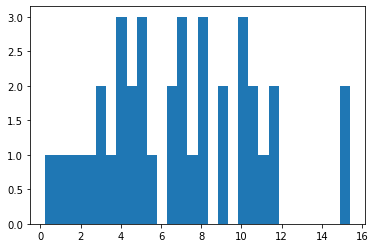

In [56]:
no_listing=2 # you can change this number to check different distribution of the distance for a certain listing id
plt.hist(list(df.iloc[no_listing-1:no_listing,1:-1].values),30)

In [102]:
df_new=pd.DataFrame(columns=['listing_id','min_distance','no_1km','no_3km'])
df_new['listing_id']=df['listing_id']
df_sub=df.iloc[:,1:-1]
df_new['min_distance']=[min(df_sub.iloc[i]) for i in range(len(df_sub))]
df_new['no_1km']=[sum(df_sub.iloc[i]<1) for i in range(len(df_sub))]
df_new['no_3km']=[sum(df_sub.iloc[i]<3) for i in range(len(df_sub))]
df_new

,listing_id,min_distance,no_1km,no_3km
0,6998418,3.465477,0,0
1,2046604,0.253532,2,6
2,7563513,0.308259,1,5
3,3071445,1.146688,0,3
4,9667539,1.380337,0,1
...,...,...,...,...
26043,2322717,1.246629,0,6
26044,3161844,1.285099,0,8
26045,2402528,0.706502,3,3
26046,8150354,0.555852,2,2


In [109]:
def new_distance_attribute(type,aux_name,threshold_1=1,threshold_2=3):
    '''
    This function is used to generate new distance related attributes, including 'min_distance','no_1km','no_3km'. The thresholds of last two attributes (1 km and 3 km) can be changed.
    :param type: str. 'train' or 'test'
    :param aux_names: str. the auxiliary name
    :param threshold1: int. default is 1
    :param threshold2: int. default is 3
    :return: save a new csv file to local './distance_attributes/{type}-{aux_name}.csv', containing 'min_distance','no_threshold_1','no_threshold_2'
    '''
    if not os.path.exists('./distance_attributes/'):os.makedirs('./distance_attributes/')

    df=pd.read_csv(f'./distance/{type}-{aux_name}.csv')

    df_new=pd.DataFrame(columns=['listing_id','min_distance',f'no_{threshold_1}km',f'no_{threshold_2}km'])
    df_new['listing_id']=df['listing_id']
    df_sub=df.iloc[:,1:-1]
    df_new['min_distance']=[min(df_sub.iloc[i]) for i in range(len(df_sub))]
    df_new[f'no_{threshold_1}km']=[sum(df_sub.iloc[i]<threshold_1) for i in range(len(df_sub))]
    df_new[f'no_{threshold_2}km']=[sum(df_sub.iloc[i]<threshold_2) for i in range(len(df_sub))]
    df_new.to_csv(f'./distance_attributes/{type}-{aux_name}.csv')


In [110]:
# read the data matrix file
aux_names=['commercial','gov-markets-hawker-centers','shopping-malls','secondary-schools','primary-schools','train-stations']
for type in ['train','test']:
    for i in range(len(aux_names)):
        new_distance_attribute(type,aux_names[i],threshold_1=1,threshold_2=3)

In [134]:
#merge the attributes
for type in ['train','test']:
    for i in range(len(aux_names)):
        df=pd.read_csv(f'./distance_attributes/{type}-{aux_names[i]}.csv')
        threshold_1=df.columns[3][3]
        threshold_2=df.columns[4][3]
        oldname_col=df.columns[2:5]
        newname_col=[f'{aux_names[i][:5]}_min_distance',
                    f'{aux_names[i][:5]}_no_{threshold_1}km',
                    f'{aux_names[i][:5]}_no_{threshold_2}km']
        df.rename(columns=dict(zip(oldname_col, newname_col)),inplace=True)
        if i ==0 :
            df_new=df.iloc[:,1:]
        else:
            df_new=pd.merge(df_new,df.iloc[:,1:],on='listing_id')
    df_new.to_csv(f'./distance_attributes/{type}_distance_attributes.csv')

In [5]:
# we can check the columns in the new dataset
# train data set
pd.read_csv(f'./distance_attributes/train_distance_attributes.csv').columns[2:]

Index(['comme_min_distance', 'comme_no_1km', 'comme_no_3km',
       'gov-m_min_distance', 'gov-m_no_1km', 'gov-m_no_3km',
       'shopp_min_distance', 'shopp_no_1km', 'shopp_no_3km',
       'secon_min_distance', 'secon_no_1km', 'secon_no_3km',
       'prima_min_distance', 'prima_no_1km', 'prima_no_3km',
       'train_min_distance', 'train_no_1km', 'train_no_3km'],
      dtype='object')

In [6]:
# test data set
pd.read_csv(f'./distance_attributes/test_distance_attributes.csv').columns[2:]

Index(['comme_min_distance', 'comme_no_1km', 'comme_no_3km',
       'gov-m_min_distance', 'gov-m_no_1km', 'gov-m_no_3km',
       'shopp_min_distance', 'shopp_no_1km', 'shopp_no_3km',
       'secon_min_distance', 'secon_no_1km', 'secon_no_3km',
       'prima_min_distance', 'prima_no_1km', 'prima_no_3km',
       'train_min_distance', 'train_no_1km', 'train_no_3km'],
      dtype='object')

# Distributions of new attributes

Now let us check how these new attributes look like.

In [4]:
# read these new attributes (we only test 'train dataset' here)
data=pd.read_csv(f'./distance_attributes/train_distance_attributes.csv')

In [5]:
attribute_name=data.columns[2:]
attribute_name

Index(['comme_min_distance', 'comme_no_1km', 'comme_no_3km',
       'gov-m_min_distance', 'gov-m_no_1km', 'gov-m_no_3km',
       'shopp_min_distance', 'shopp_no_1km', 'shopp_no_3km',
       'secon_min_distance', 'secon_no_1km', 'secon_no_3km',
       'prima_min_distance', 'prima_no_1km', 'prima_no_3km',
       'train_min_distance', 'train_no_1km', 'train_no_3km'],
      dtype='object')

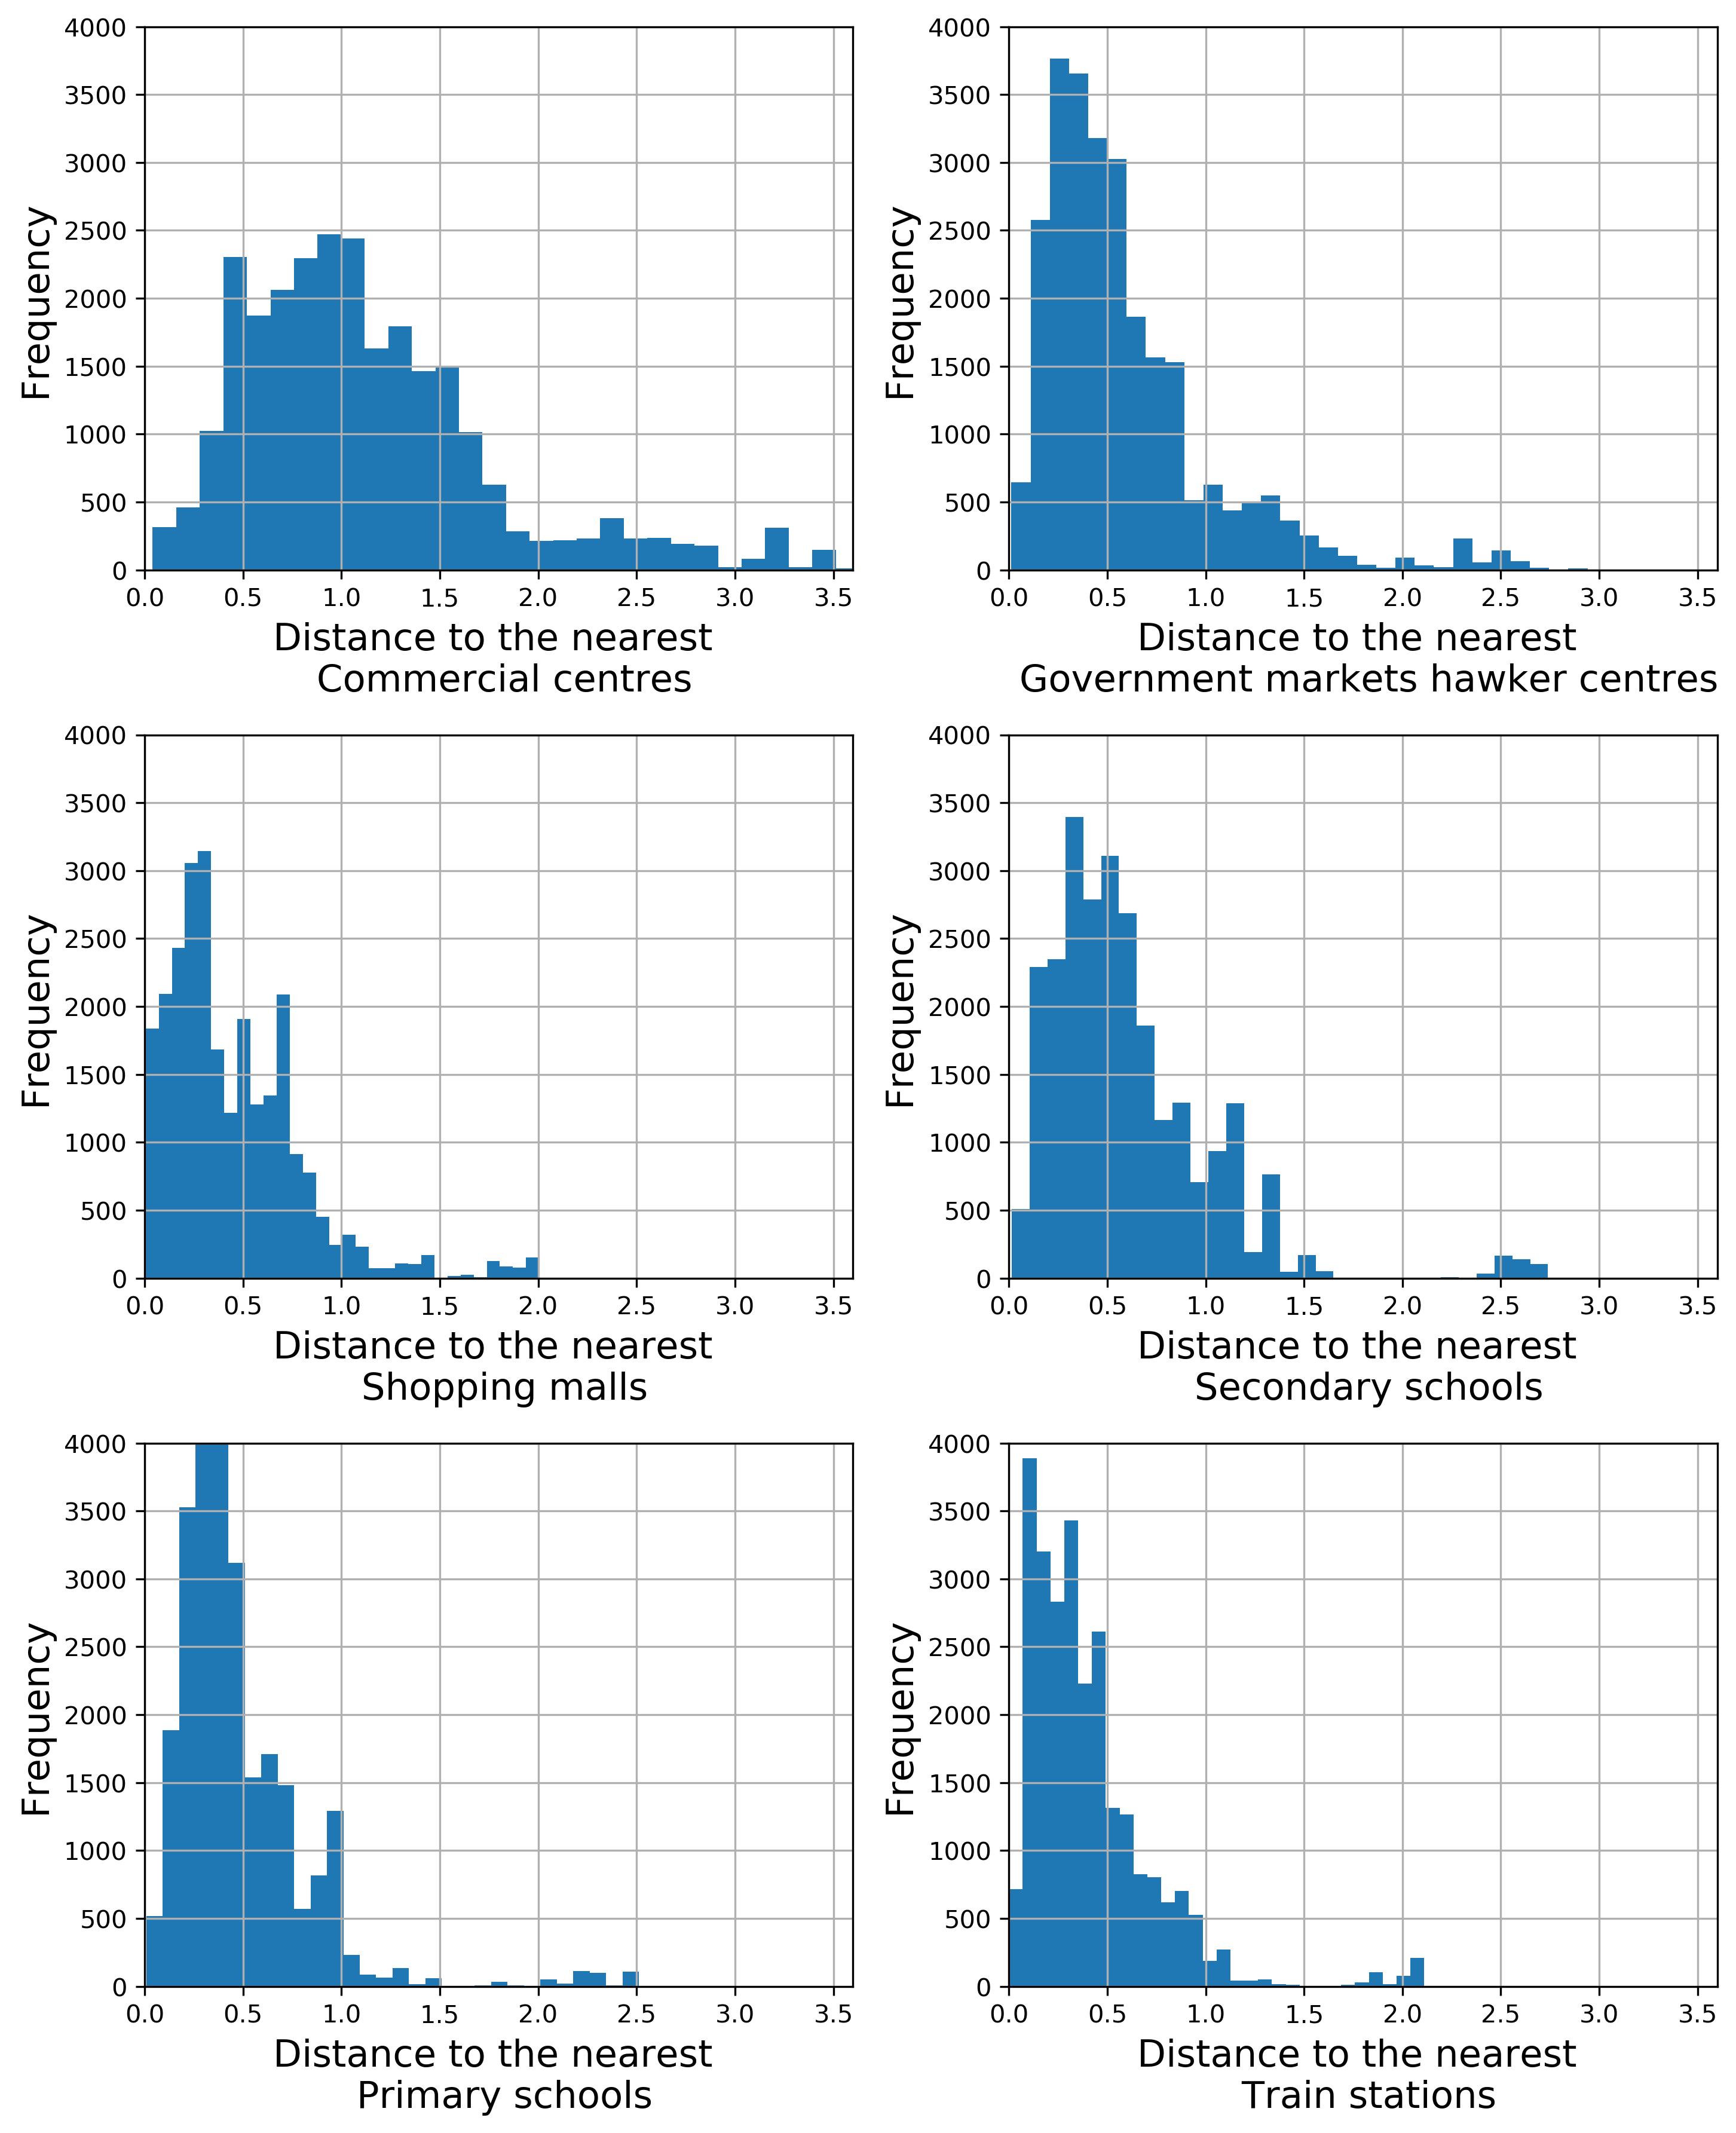

In [18]:
fig=plt.figure(dpi=300,figsize=(10,12))
letters=['a','b','c','d','e','f']
aux=['Commercial centres','Government markets hawker centres','Shopping malls','Secondary schools','Primary schools','Train stations']
for i in range(6):
    fig.add_subplot(3,2,i+1)
    plt.xlim(xmax=3.6,xmin=0)
    plt.ylim(ymax=4000,ymin=0)
    attr=attribute_name[i*3]
    plt.hist(data[attr],30)
    plt.grid(True)
    plt.xlabel(f'Distance to the nearest \n {aux[i]}',size=15)
    plt.ylabel('Frequency',size=15)
    # plt.title(f'({letters[i]}) {aux[i]}',y=-0.2)
# plt.suptitle('Distance to the nearest landmarks')
plt.tight_layout()
plt.savefig('image/distribution_min_aux.png')

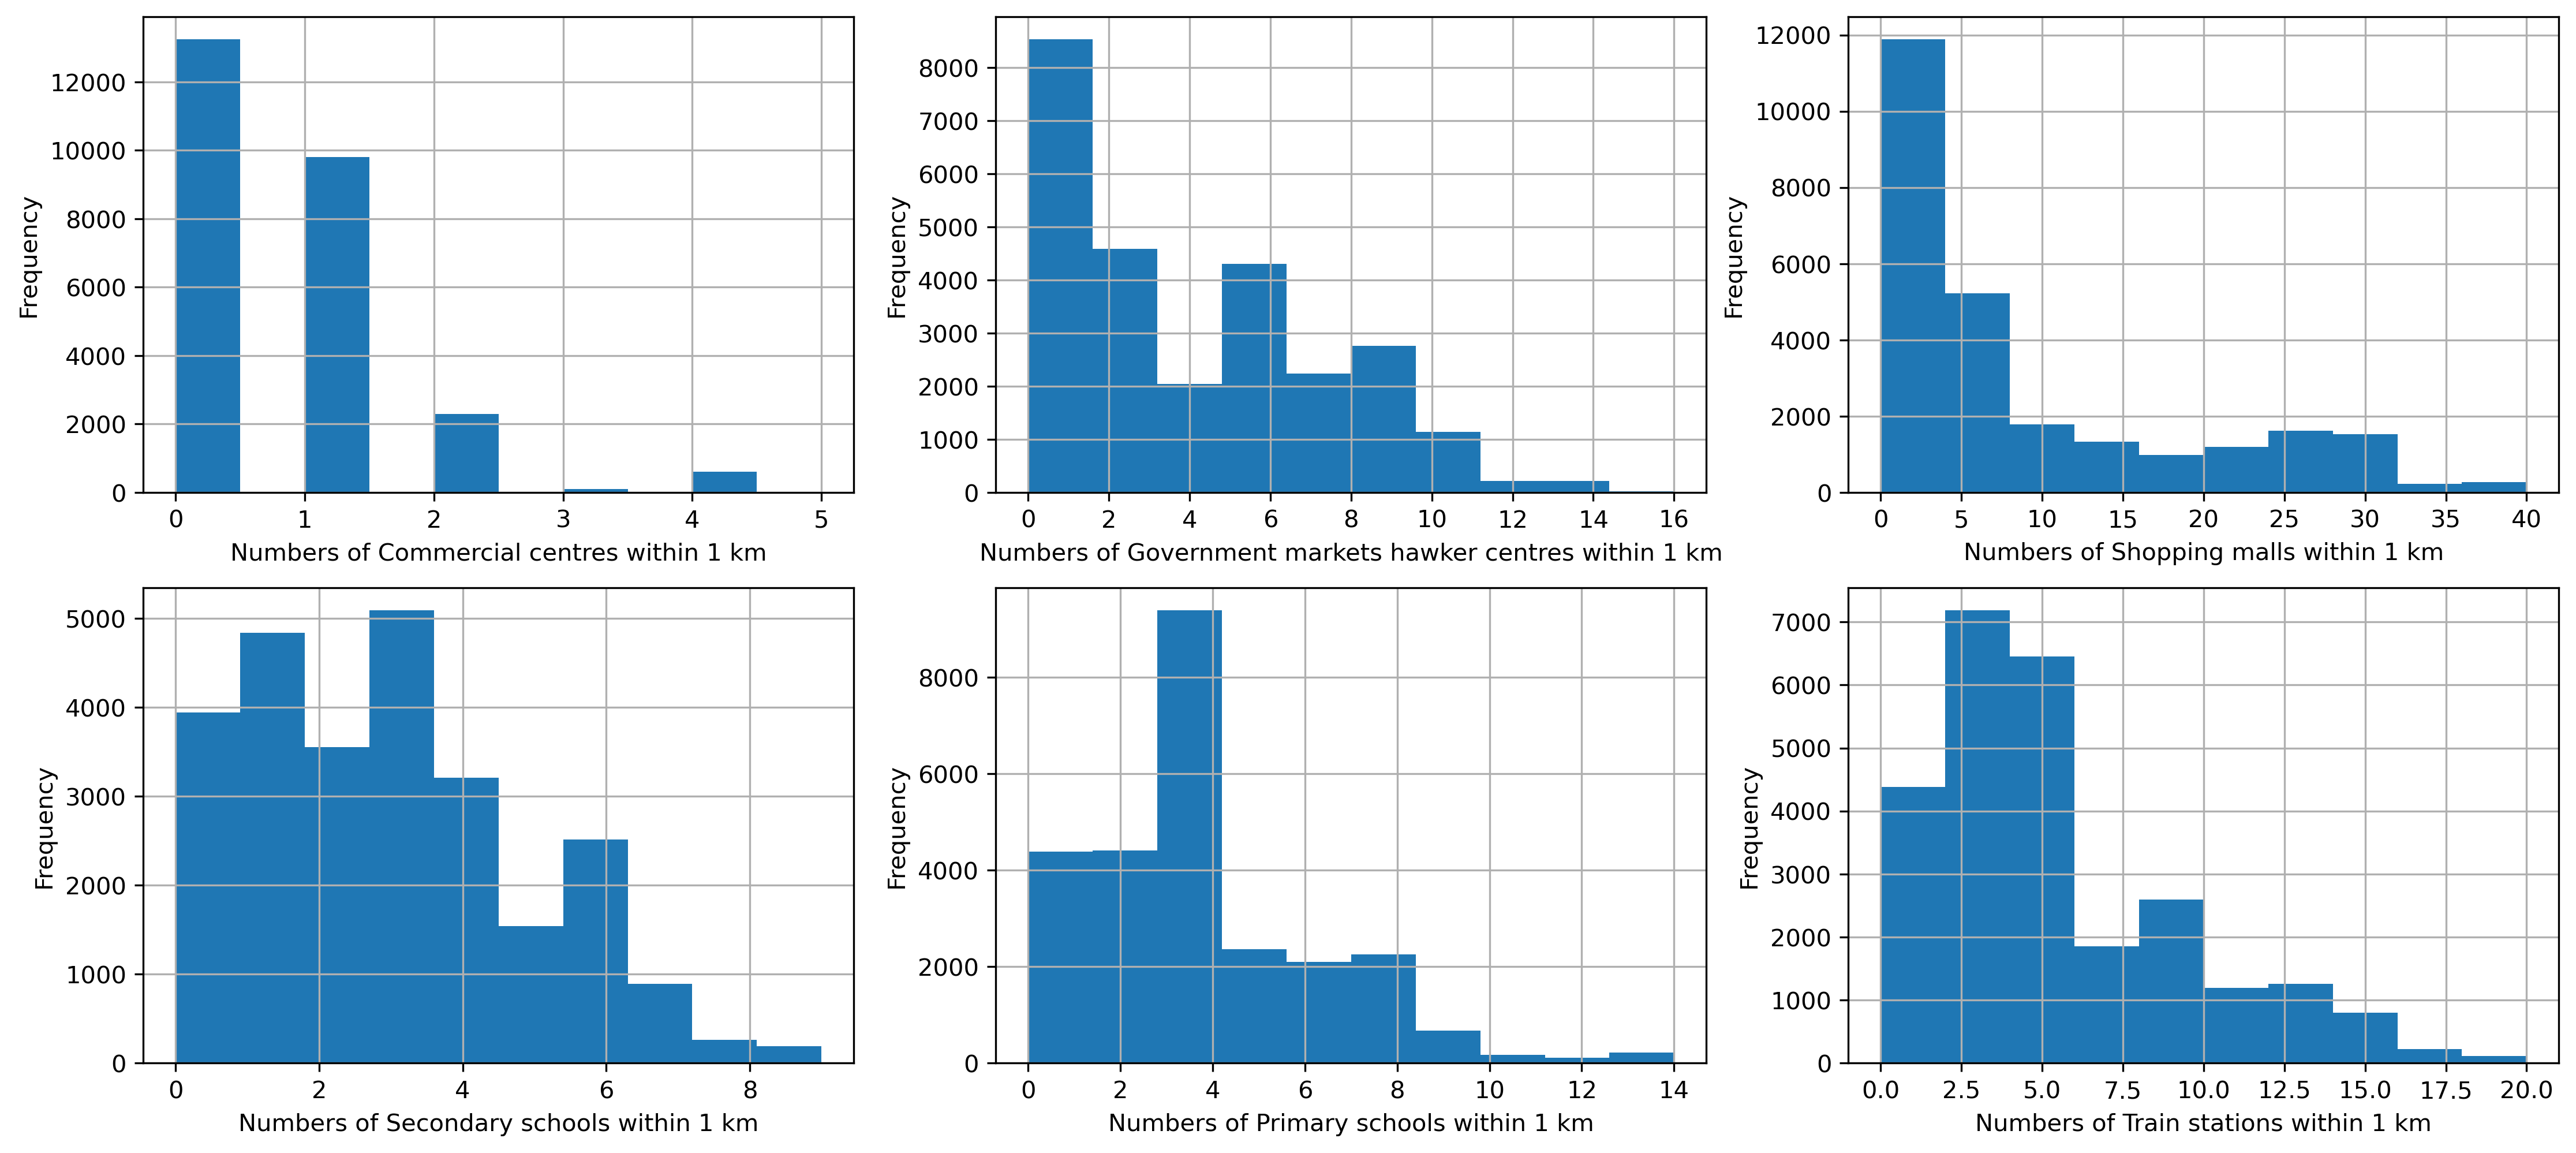

In [44]:
fig=plt.figure(dpi=300,figsize=(18,8))
letters=['a','b','c','d','e','f']
aux=['Commercial centres','Government markets hawker centres','Shopping malls','Secondary schools','Primary schools','Train stations']
for i in range(6):
    fig.add_subplot(2,3,i+1)
    # plt.xlim(xmax=3.6,xmin=0)
    attr=attribute_name[i*3+1]
    plt.hist(data[attr],10)
    plt.grid(True)
    plt.xlabel(f'Numbers of {aux[i]} within 1 km')
    plt.ylabel('Frequency')
    # plt.title(f'({letters[i]}) {aux[i]}',y=-0.2)

plt.savefig('image/No_aux_in_1k.png')

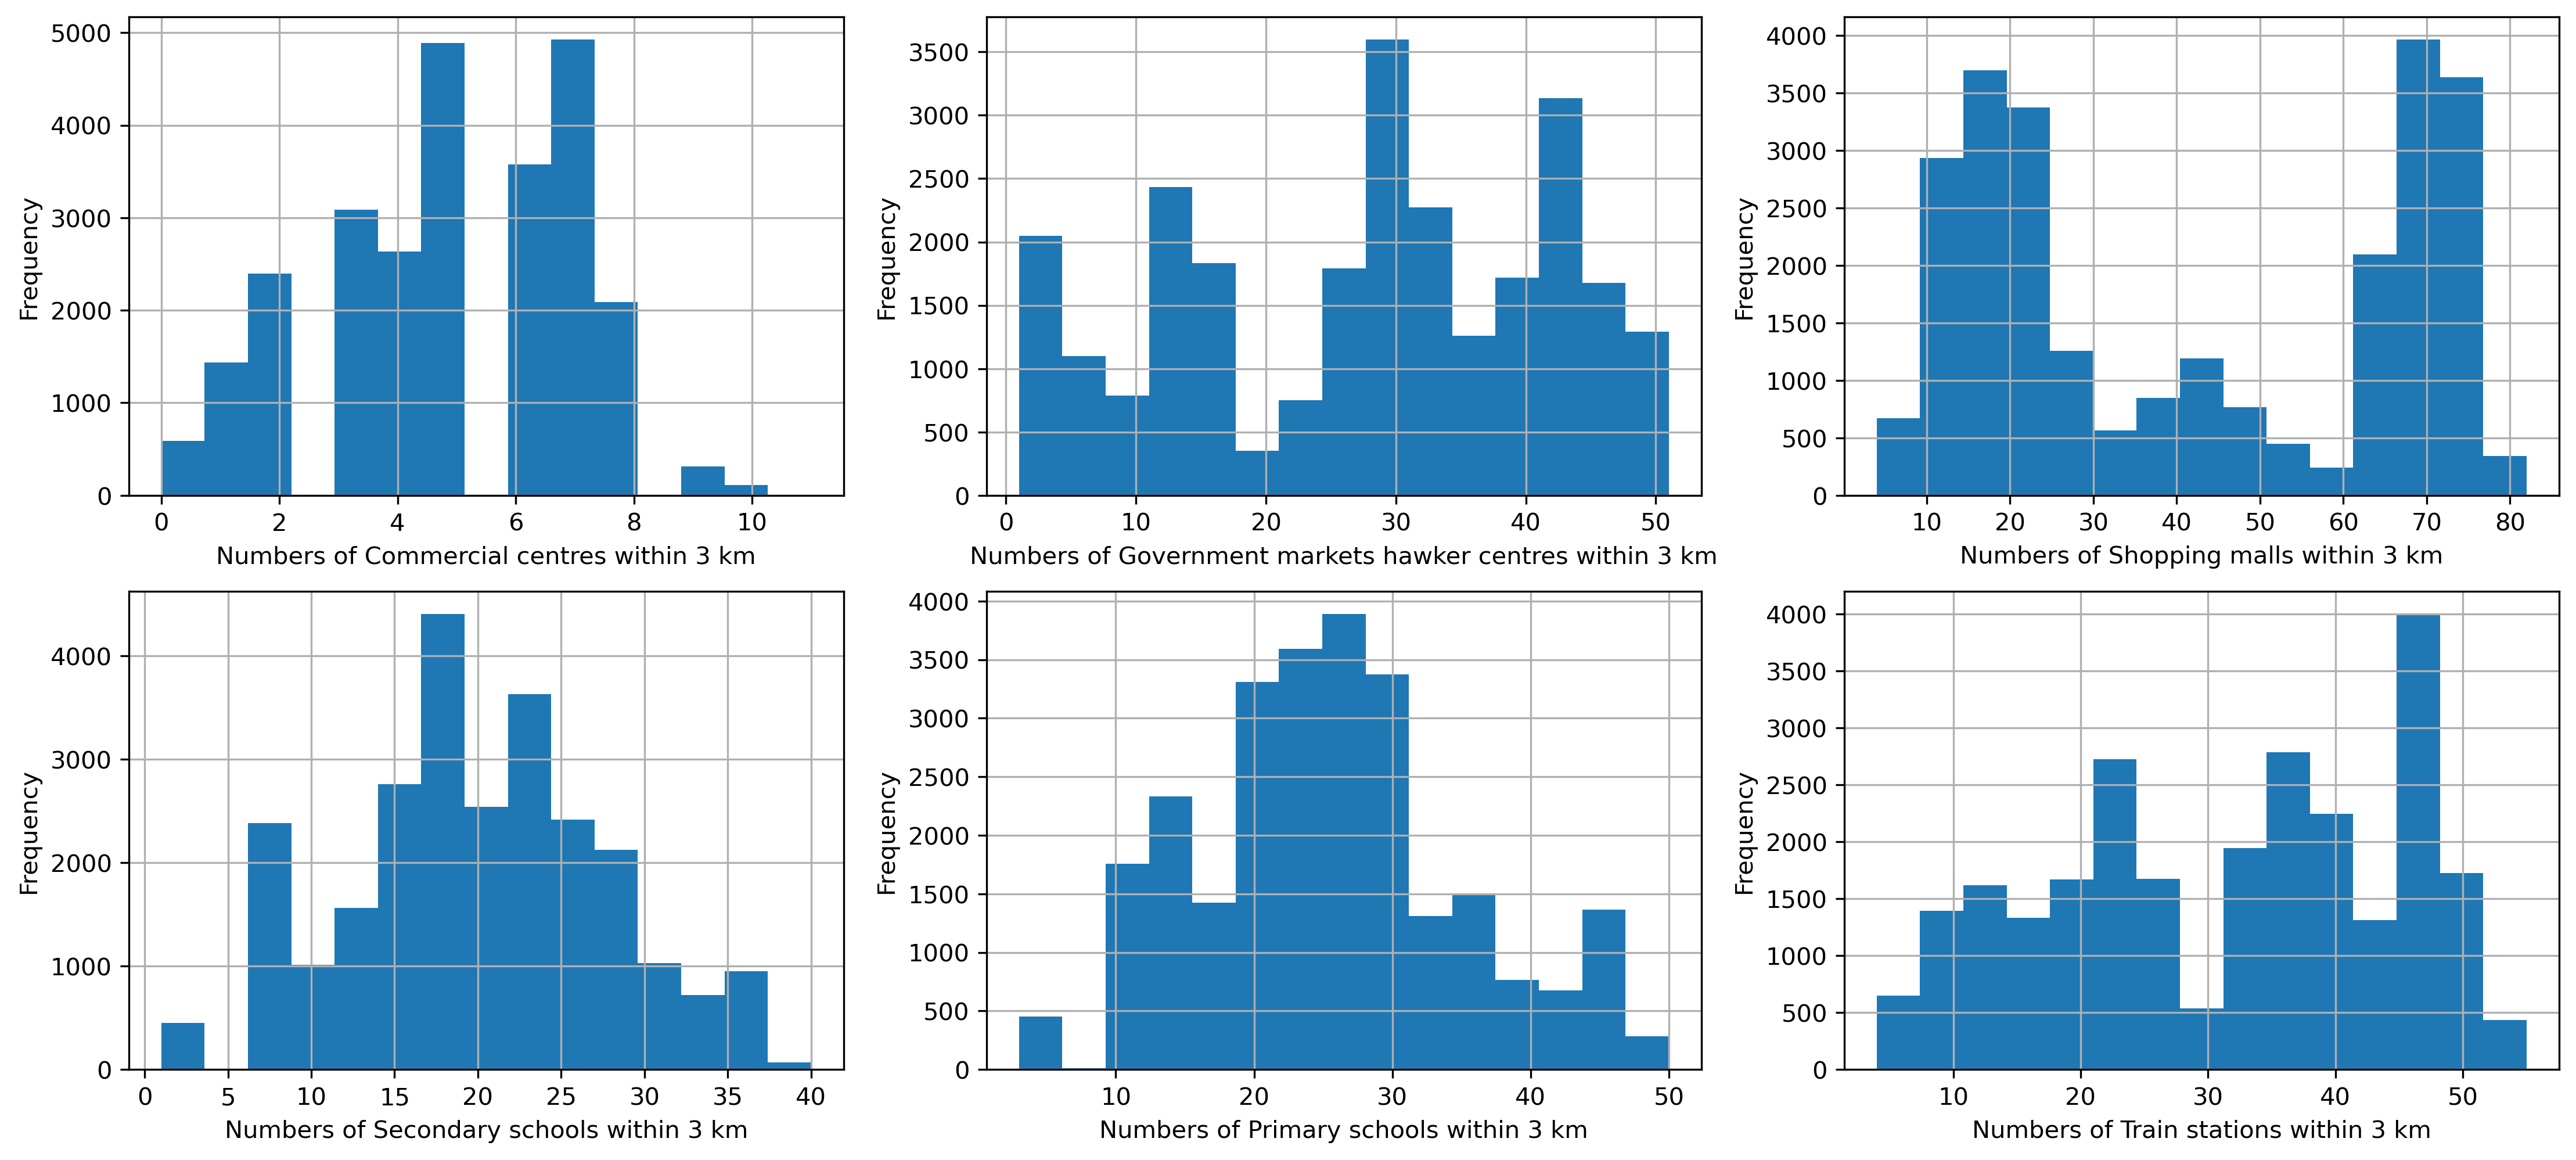

In [45]:
fig=plt.figure(dpi=300,figsize=(18,8))
letters=['a','b','c','d','e','f']
aux=['Commercial centres','Government markets hawker centres','Shopping malls','Secondary schools','Primary schools','Train stations']
for i in range(6):
    fig.add_subplot(2,3,i+1)
    # plt.xlim(xmax=3.6,xmin=0)
    attr=attribute_name[i*3+2]
    plt.hist(data[attr],15)
    plt.grid(True)
    plt.xlabel(f'Numbers of {aux[i]} within 3 km')
    plt.ylabel('Frequency')
    # plt.title(f'({letters[i]}) {aux[i]}',y=-0.2)

plt.savefig('image/No_aux_in_3k.png')

# Merge the dataset

In [19]:
train=pd.read_csv('dataset/train_ziji_mar27.csv')
test=pd.read_csv('dataset/test_ziji_mar27.csv')

train_dist=pd.read_csv('distance_attributes/train_distance_attributes.csv')
test_dist=pd.read_csv('distance_attributes/test_distance_attributes.csv')

train=pd.merge(train,train_dist,on='listing_id').drop(columns='Unnamed: 0')
test=pd.merge(test,test_dist,on='listing_id').drop(columns='Unnamed: 0')

In [22]:
train.to_csv('dataset/train_yutong.csv')
test.to_csv('dataset/test_yutong.csv')